<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [1]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

## Detect available device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Definition of an activation function and its derivatives

In [3]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [4]:
class WaveFunction(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(WaveFunction, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1]


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape) #[None] * self.N #
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N).to(device)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian

In [125]:
def A(x_):
  p = torch.ones(x_.shape[0]).to(device)

  for i in range(x_.shape[1]):
    p *= (x_[:,i] - 1/2)**2-1/4

  return p
  
def Ax(x_):
  p = torch.ones(x_.shape).to(device)

  for i in range(x_.shape[1]):
    p[:, i] = A(x_) * 2 * (x_[:,i] - 1/2) / ((x_[:,i] - 1/2)**2-1/4)

  return p
  
def Axx(x_):
  return 2 * A(x_) * torch.sum( ((x_ - 1/2)**2 - 1/4)**(-1), axis=1 )

def train_loop(N, N_batch, M, wf, optimizer):#, eigval):
  """
  N --- a size of the input vector, its dimension
  M --- total number of iterations
  """

  loss_fn = nn.L1Loss()
  
  for i in range(M):
    x_test = torch.rand((N_batch, N)).to(device)

    phi_test = wf(x_test).reshape(len(x_test)).to(device)
    phix_test = wf.grad(x_test).to(device)
    phixx_test = wf.laplac(x_test).reshape(len(x_test)).to(device)

    # если задавать нужное значение энергии, то всё получается
    # I = torch.mean( (phixx_test * A(x_test) \
    #                  + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
    #                  + Axx(x_test) * phi_test \
    #                  + eigval*phi_test*A(x_test))**2 )
    
    # I = torch.mean(torch.abs(phixx_test * A(x_test)\
    #                  + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
    #                  + Axx(x_test) * phi_test))\
    #     / (torch.mean(torch.abs(phi_test * A(x_test))))

    I = torch.mean( (phixx_test * A(x_test) \
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
                     + Axx(x_test) * phi_test \
                     + torch.mean(torch.abs(phixx_test * A(x_test)\
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
                     + Axx(x_test) * phi_test))\
        / (torch.mean(torch.abs(phi_test * A(x_test))))*phi_test*A(x_test))**2 )

    # Compute loss
    loss = loss_fn(I, torch.tensor(0.0).to(device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if np.isnan(loss.item()):
      print(f'{i:} LOSS FUNCTION IS NAN')
      break

    if (i+1) % 100 == 0:
      E = torch.mean(torch.abs(phixx_test * A(x_test)\
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1)\
                     + Axx(x_test) * phi_test))\
        / (torch.mean(torch.abs(phi_test * A(x_test))))
      print(f"Residual: {loss.item():>0.5E}, Energy: {E:>0.5f}  [{i+1:>5d} / {M:>5d}]")

# 1D

In [126]:
def plot_compar_1d(wf):
  x = torch.linspace(1e-2,1-1e-2,100).reshape((-1, N)).to(device)
  y = wf(x) * A(x).reshape((-1,N))

  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()

  plt.plot(x, (y/y.mean())**2,
           label='What we get')
  
  plt.plot(x, (np.sin(x*np.pi)/np.sin(x*np.pi).mean())**2,
           label='What we should get')

  plt.legend()
  plt.xlim(0,1)
  plt.ylim(0.0,None)

  plt.show()

## Initialization of our wavefunction

In [129]:
N = 1  # size of the input vector
wf = WaveFunction(N, [10]*3).to(device) ## число внутренних слоёв должно быть той же четности, что и номер состояния

## Its training


 Epoch 1
-------------------------------
Residual: 2.95818E-05, Energy: 8.88972  [  100 /  1000]
Residual: 1.56856E-06, Energy: 9.99012  [  200 /  1000]
Residual: 2.08438E-06, Energy: 9.95709  [  300 /  1000]
Residual: 4.24155E-06, Energy: 9.70853  [  400 /  1000]
Residual: 7.39348E-07, Energy: 9.91599  [  500 /  1000]
Residual: 1.01400E-07, Energy: 9.83215  [  600 /  1000]
Residual: 5.55732E-07, Energy: 9.92809  [  700 /  1000]
Residual: 4.32988E-07, Energy: 9.76441  [  800 /  1000]
Residual: 4.71154E-08, Energy: 9.92442  [  900 /  1000]
Residual: 9.20672E-08, Energy: 9.82372  [ 1000 /  1000]


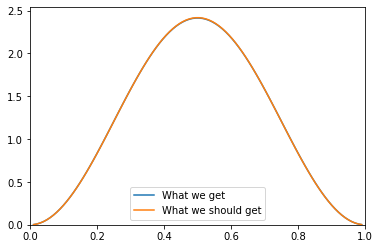


 Epoch 2
-------------------------------
Residual: 7.61071E-08, Energy: 9.85042  [  100 /  1000]
Residual: 3.61278E-08, Energy: 9.86839  [  200 /  1000]
Residual: 1.11038E-07, Energy: 9.91162  [  300 /  1000]
Residual: 2.41722E-06, Energy: 9.58782  [  400 /  1000]
Residual: 2.10436E-07, Energy: 9.84055  [  500 /  1000]
Residual: 4.74903E-07, Energy: 9.94916  [  600 /  1000]
Residual: 1.90835E-07, Energy: 9.82420  [  700 /  1000]
Residual: 6.21322E-06, Energy: 9.56050  [  800 /  1000]
Residual: 1.89538E-06, Energy: 9.80146  [  900 /  1000]
Residual: 5.52179E-07, Energy: 9.77589  [ 1000 /  1000]


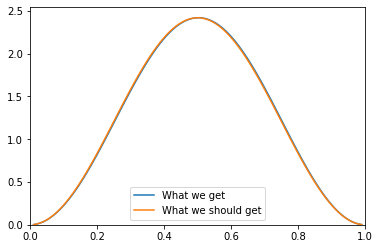


 Epoch 3
-------------------------------
Residual: 2.69998E-08, Energy: 9.88312  [  100 /  1000]
Residual: 5.45426E-09, Energy: 9.86078  [  200 /  1000]
Residual: 8.27095E-08, Energy: 9.95509  [  300 /  1000]
Residual: 5.16697E-08, Energy: 9.86246  [  400 /  1000]
Residual: 1.89402E-07, Energy: 9.90948  [  500 /  1000]
Residual: 2.35443E-06, Energy: 9.36313  [  600 /  1000]
Residual: 1.01693E-05, Energy: 9.32805  [  700 /  1000]
Residual: 1.38992E-07, Energy: 10.24927  [  800 /  1000]
Residual: 1.21113E-08, Energy: 10.05017  [  900 /  1000]
Residual: 5.30648E-08, Energy: 10.46675  [ 1000 /  1000]


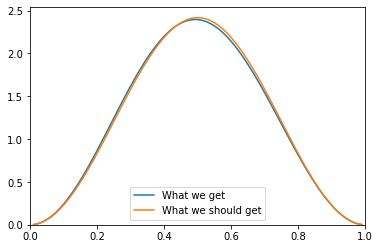

In [130]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 3
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)#, np.pi**2)
  scheduler.step()
  plot_compar_1d(wf)

# 2D

In [131]:
def plot_compare_2d(wf):
  n = 100 # number of points over one dimension
  x = np.linspace(0,1,n)
  xs, ys = np.meshgrid(x,x, sparse=True)
  
  X = np.array([[xs[0,i], ys[j,0]] for i in range(100) for j in range(100)])
  X = torch.tensor(X).to(device)

  phi = wf(X.float()).reshape(len(X)).to(device) \
        * A(X.float()).reshape(len(X)).to(device)
  sin = torch.sin(np.pi*X[:,0].float())*torch.sin(np.pi*X[:,1].float())

  phi = phi.reshape(100,100).cpu().detach().numpy()
  sin = sin.reshape(100,100).cpu().detach().numpy()

  fig, ax = plt.subplots(1, 2, figsize=(14,5))

  pcm0 = ax[0].contourf(x, x, (phi/phi.mean())**2)

  fig.colorbar(pcm0, ax=ax[0], extend='max')

  pcm1 = ax[1].contourf(x, x, (sin/sin.mean())**2)

  fig.colorbar(pcm1, ax=ax[1], extend='max')

  ax[0].set_xlabel(r'$x_1$')
  ax[0].set_ylabel(r'$x_2$')

  ax[1].set_xlabel(r'$x_1$')
  ax[1].set_ylabel(r'$x_2$')

  ax[0].set_title(r'What $|\psi|^2$ we get')
  ax[1].set_title(r'What $|\psi|^2$ we should get')

  plt.show()

In [133]:
N = 2
wf = WaveFunction(N, [10**N]*3).to(device) 


 Epoch 1
-------------------------------
Residual: 7.44106E-07, Energy: 23.22067  [  100 /  1000]
Residual: 1.35582E-07, Energy: 20.92698  [  200 /  1000]
Residual: 6.68454E-08, Energy: 21.11847  [  300 /  1000]
Residual: 1.48397E-07, Energy: 28.24014  [  400 /  1000]
Residual: 1.07741E-08, Energy: 19.67249  [  500 /  1000]
Residual: 8.36361E-09, Energy: 20.13058  [  600 /  1000]
Residual: 5.10059E-09, Energy: 19.87935  [  700 /  1000]
Residual: 5.45699E-09, Energy: 20.15314  [  800 /  1000]
Residual: 5.61325E-09, Energy: 20.29893  [  900 /  1000]
Residual: 3.64452E-09, Energy: 20.03370  [ 1000 /  1000]


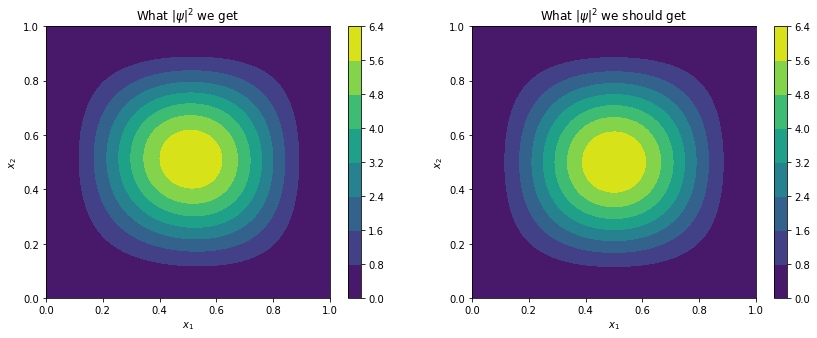


 Epoch 2
-------------------------------
Residual: 5.92334E-09, Energy: 19.97359  [  100 /  1000]
Residual: 9.81705E-09, Energy: 19.82791  [  200 /  1000]
Residual: 5.66277E-09, Energy: 19.61770  [  300 /  1000]
Residual: 1.86273E-06, Energy: 24.45485  [  400 /  1000]
Residual: 1.22947E-06, Energy: 25.59255  [  500 /  1000]
Residual: 1.12303E-08, Energy: 20.19671  [  600 /  1000]
Residual: 7.45493E-09, Energy: 20.10304  [  700 /  1000]
Residual: 5.16058E-09, Energy: 19.82471  [  800 /  1000]
Residual: 5.11274E-09, Energy: 19.07891  [  900 /  1000]
Residual: 2.79025E-09, Energy: 19.87513  [ 1000 /  1000]


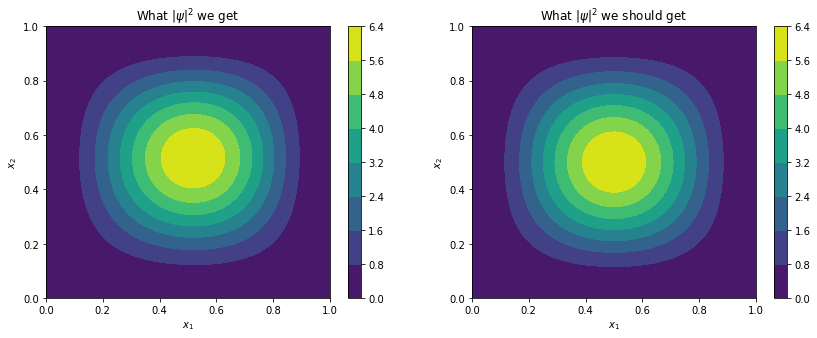


 Epoch 3
-------------------------------
Residual: 2.17184E-09, Energy: 19.84357  [  100 /  1000]
Residual: 3.37515E-09, Energy: 19.08987  [  200 /  1000]
Residual: 1.83480E-09, Energy: 19.38831  [  300 /  1000]
Residual: 8.81890E-10, Energy: 19.90234  [  400 /  1000]
Residual: 8.15947E-10, Energy: 20.06384  [  500 /  1000]
Residual: 1.86690E-08, Energy: 25.85535  [  600 /  1000]
Residual: 1.29248E-07, Energy: 59.37836  [  700 /  1000]
Residual: 1.90770E-06, Energy: 23.36262  [  800 /  1000]
Residual: 3.41406E-09, Energy: 21.46273  [  900 /  1000]
Residual: 4.62964E-10, Energy: 19.98945  [ 1000 /  1000]


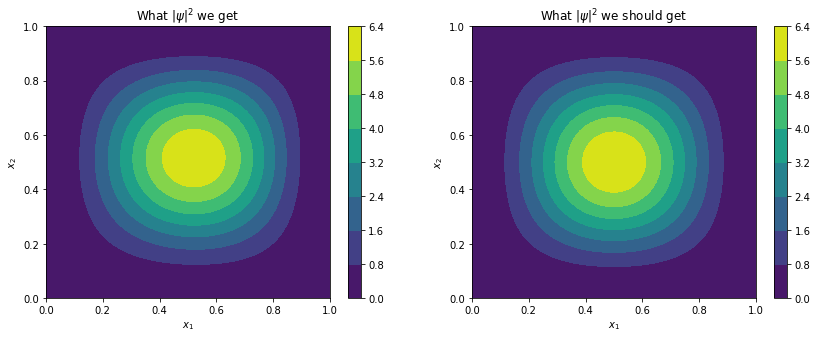


 Epoch 4
-------------------------------
Residual: 6.89632E-10, Energy: 19.59555  [  100 /  1000]
Residual: 4.69842E-10, Energy: 20.52950  [  200 /  1000]
Residual: 3.70927E-10, Energy: 19.63291  [  300 /  1000]
Residual: 5.69907E-10, Energy: 20.33250  [  400 /  1000]
Residual: 4.64590E-10, Energy: 19.32565  [  500 /  1000]
Residual: 8.06284E-10, Energy: 20.76199  [  600 /  1000]
Residual: 6.86486E-09, Energy: 22.05112  [  700 /  1000]
Residual: 2.25218E-07, Energy: 21.54813  [  800 /  1000]
Residual: 5.49890E-06, Energy: 25.31052  [  900 /  1000]
Residual: 1.27316E-07, Energy: 52.18913  [ 1000 /  1000]


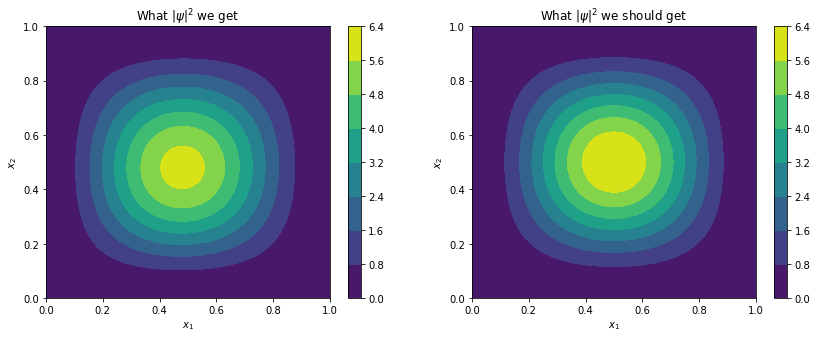


 Epoch 5
-------------------------------
Residual: 1.05114E-09, Energy: 19.83162  [  100 /  1000]
Residual: 6.41708E-10, Energy: 19.75288  [  200 /  1000]
Residual: 6.92667E-10, Energy: 19.60719  [  300 /  1000]
Residual: 5.19860E-10, Energy: 19.72636  [  400 /  1000]
Residual: 5.02768E-10, Energy: 19.81050  [  500 /  1000]
Residual: 5.39667E-10, Energy: 19.69831  [  600 /  1000]
Residual: 4.93588E-10, Energy: 19.81037  [  700 /  1000]
Residual: 4.93544E-10, Energy: 19.64422  [  800 /  1000]
Residual: 4.89795E-10, Energy: 19.80010  [  900 /  1000]
Residual: 4.12608E-10, Energy: 19.85941  [ 1000 /  1000]


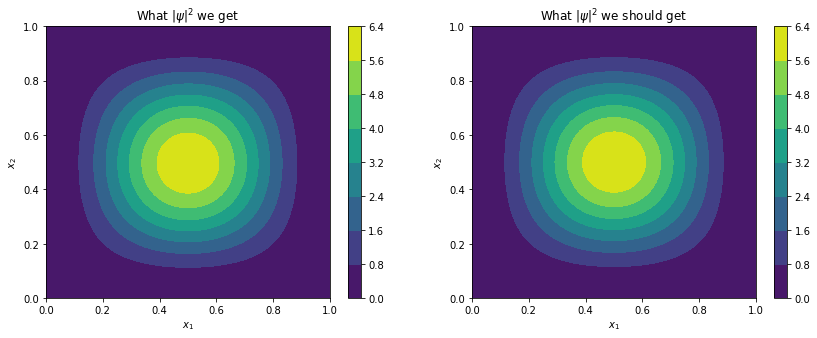

In [134]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)#, 2*np.pi**2)
  scheduler.step()
  plot_compare_2d(wf)

# 3D

In [135]:
N = 3
wf = WaveFunction(N, [100]*3).to(device)

In [136]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 500, wf, optimizer)#, 3*np.pi**2)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 1.53655E-08, Energy: 93.91266  [  100 /   500]
Residual: 4.54983E-10, Energy: 29.57422  [  200 /   500]
Residual: 3.13116E-10, Energy: 29.70739  [  300 /   500]
Residual: 1.89400E-10, Energy: 29.55831  [  400 /   500]
Residual: 1.49500E-10, Energy: 29.70504  [  500 /   500]

 Epoch 2
-------------------------------
Residual: 1.08016E-10, Energy: 29.70495  [  100 /   500]
Residual: 8.92911E-11, Energy: 29.63875  [  200 /   500]
Residual: 8.50510E-11, Energy: 29.63681  [  300 /   500]
Residual: 6.84864E-11, Energy: 29.62641  [  400 /   500]
Residual: 6.08014E-11, Energy: 29.62657  [  500 /   500]

 Epoch 3
-------------------------------
Residual: 5.47495E-11, Energy: 29.65532  [  100 /   500]
Residual: 5.40340E-11, Energy: 29.58926  [  200 /   500]
Residual: 4.10457E-11, Energy: 29.64453  [  300 /   500]
Residual: 4.03912E-11, Energy: 29.69754  [  400 /   500]
Residual: 4.28866E-11, Energy: 29.57711  [  500 /   500]

 Epoch 4
---------